In [2]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

GRAPHS_DIR = 'graphs'
os.makedirs(GRAPHS_DIR, exist_ok=True)

In [3]:
import importlib
import experiments
importlib.reload(experiments)

<module 'experiments' from '/Users/tobias/Uni/git/pfandzelter/komet/scheduling/experiments.py'>

In [4]:
tmp = []
for exp in experiments.EXPERIMENTS:

    results_file = f"{os.path.join(experiments.RESULTS_FOLDER, exp.filename())}.csv"

    df = pd.read_csv(results_file)

    df["experiment"] = exp.name
    df["strategy"] = str(exp.strategy)

    tmp.append(df)

df = pd.concat(tmp)
df.head()

,t,ground_station,satellite,distance,experiment,strategy
0,0,sensor21413,685,25513,iotgraphextreme,many2one-rmse-0.0
1,0,sensor21414,685,7092,iotgraphextreme,many2one-rmse-0.0
2,0,sensor21415,685,8394,iotgraphextreme,many2one-rmse-0.0
3,0,sensor21416,685,10883,iotgraphextreme,many2one-rmse-0.0
4,0,sensor21417,685,15423,iotgraphextreme,many2one-rmse-0.0


In [5]:
df[(df["experiment"] == "simple")].groupby("strategy")["satellite"].unique().apply(len)

strategy
minmax-False       13
one2one-0.1        13
one2one-0.25       10
one2one-abs-500    13
Name: satellite, dtype: int64

In [6]:
# figure out the times between handoff
# go through each timestep and record if the satellite is different from the previous one
import tqdm.autonotebook as tqdm

tmp = []

for exp in tqdm.tqdm(experiments.EXPERIMENTS):
    if exp.name == "cdn":
        # does not make sense for this one
        continue

    interesting_df = df[(df["experiment"] == exp.name) & (df["strategy"] == str(exp.strategy))]

    curr_sat =  interesting_df[interesting_df["t"] == 0].sort_values("distance").iloc[0]["satellite"]
    since = 0

    for t in range(1, exp.duration, exp.resolution):
        sat = interesting_df[interesting_df["t"] == t].sort_values("distance").iloc[0]["satellite"]
        if sat != curr_sat:
            # print(f"Satellite changed to {sat} at timestep {t} (since {since}) in {exp.filename()}")
            tmp.append((
                exp.name,
                str(exp.strategy),
                curr_sat,
                sat,
                t - since,
            ))
            curr_sat = sat
            since = t

handoff_df = pd.DataFrame(tmp, columns=["experiment", "strategy", "from", "to", "duration"])
handoff_df.head()

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_54333/1731360108.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  import tqdm.autonotebook as tqdm
100%|██████████| 51/51 [00:21<00:00,  2.38it/s]


,experiment,strategy,from,to,duration
0,iotgraphextreme,many2one-rmse-0.0,685,707,2
1,iotgraphextreme,many2one-rmse-0.0,707,685,5
2,iotgraphextreme,many2one-rmse-0.0,685,903,12
3,iotgraphextreme,many2one-rmse-0.0,903,685,1
4,iotgraphextreme,many2one-rmse-0.0,685,903,3


<Axes: xlabel='distance', ylabel='Proportion'>

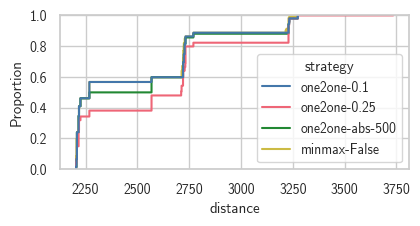

In [7]:
# ecdf for the simple case with distances
sns.ecdfplot(data=df[df["experiment"] == "simple"], x="distance", hue="strategy")
# plt.savefig(f"{GRAPHS_DIR}/distance_simple.pdf", bbox_inches='tight')

<Axes: xlabel='duration', ylabel='Proportion'>

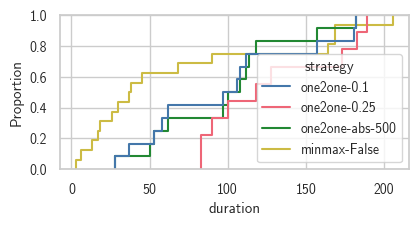

In [8]:
# ecdf for the simple case with distances
sns.ecdfplot(data=handoff_df[handoff_df["experiment"] == "simple"], x="duration", hue="strategy")
# plt.savefig(f"{GRAPHS_DIR}/handoff_duration_simple.pdf", bbox_inches='tight')

In [9]:
handoff_df[handoff_df["experiment"] == "simple"].groupby("strategy").count()

,experiment,from,to,duration
strategy,,,,
minmax-False,16,16,16,16
one2one-0.1,12,12,12,12
one2one-0.25,9,9,9,9
one2one-abs-500,12,12,12,12


<Axes: xlabel='distance', ylabel='Proportion'>

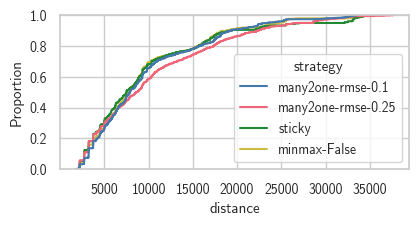

In [10]:
# ecdf for the simple case with distances
sns.ecdfplot(data=df[df["experiment"] == "iot"], x="distance", hue="strategy")
# plt.savefig(f"{GRAPHS_DIR}/distance_iot.pdf", bbox_inches='tight')

[None]

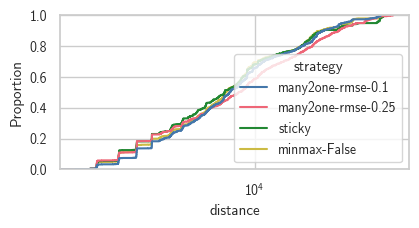

In [11]:
# ecdf for the simple case with distances
g = sns.ecdfplot(data=df[df["experiment"] == "iot"], x="distance", hue="strategy")
g.set(xscale="log")

<Axes: xlabel='distance', ylabel='Proportion'>

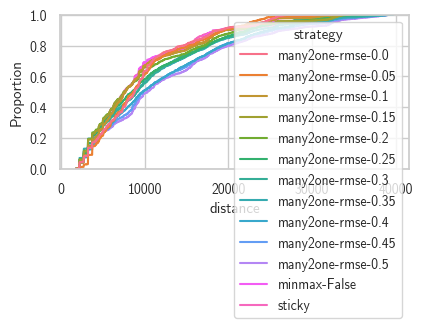

In [12]:
# ecdf for the simple case with distances
sns.ecdfplot(data=df[df["experiment"] == "iotgraphextreme"], x="distance", hue="strategy")
# plt.savefig(f"{GRAPHS_DIR}/distance_iot.pdf", bbox_inches='tight')

<Axes: xlabel='duration', ylabel='Proportion'>

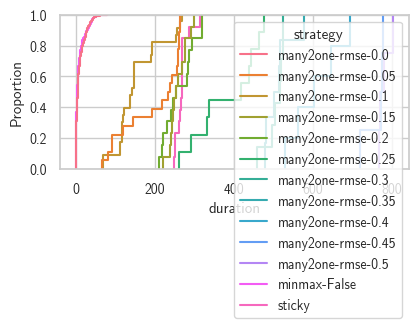

In [13]:
# ecdf for the simple case with distances
sns.ecdfplot(data=handoff_df[handoff_df["experiment"] == "iotgraphextreme"], x="duration", hue="strategy")
# plt.savefig(f"{GRAPHS_DIR}/handoff_duration_iot.pdf", bbox_inches='tight')

In [14]:
df[(df["experiment"] == "iot")].groupby("strategy")["satellite"].unique().apply(len)

strategy
many2one-rmse-0.1      6
many2one-rmse-0.25     4
minmax-False          26
sticky                 5
Name: satellite, dtype: int64

<Axes: xlabel='duration', ylabel='Proportion'>

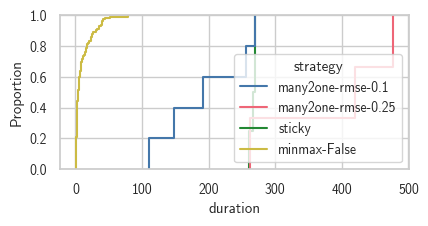

In [15]:
# ecdf for the simple case with distances
sns.ecdfplot(data=handoff_df[handoff_df["experiment"] == "iot"], x="duration", hue="strategy")
# plt.savefig(f"{GRAPHS_DIR}/handoff_duration_iot.pdf", bbox_inches='tight')

<Axes: xlabel='distance', ylabel='Proportion'>

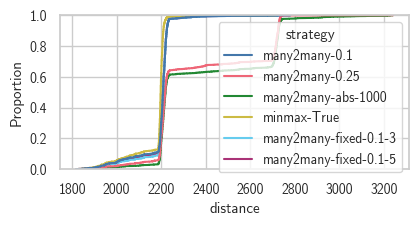

In [16]:
# ecdf for the simple case with distances
sns.ecdfplot(data=df[df["experiment"] == "cdn"], x="distance", hue="strategy")
# plt.savefig(f"{GRAPHS_DIR}/distance_cdn.pdf", bbox_inches='tight')

<Axes: xlabel='satellite', ylabel='Proportion'>

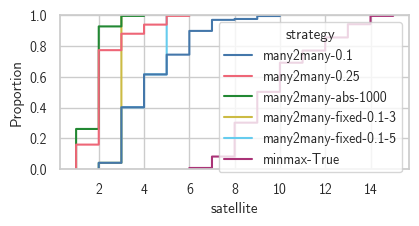

In [17]:
cdn_num_sat_df = df[(df["experiment"] == "cdn")].groupby(["t", "strategy"])["satellite"].unique().apply(len).reset_index()
sns.ecdfplot(data=cdn_num_sat_df, x="satellite", hue="strategy")
# plt.savefig(f"{GRAPHS_DIR}/num_satellites_cdn.pdf", bbox_inches='tight')

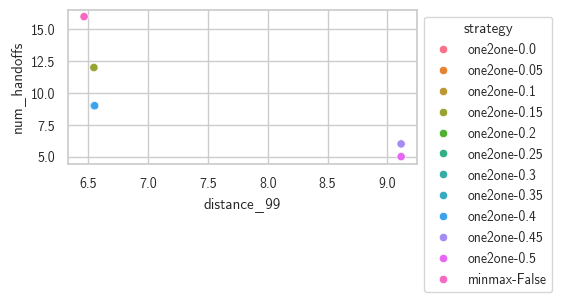

In [18]:
# finally: iotgraph
points = []
point_df = df[(df["experiment"] == "simplegraph")]

# go through unique strategies
for t in point_df["strategy"].unique():
    # figure out the number of handoffs
    num_handoffs = handoff_df[(handoff_df["experiment"] == "simplegraph") & (handoff_df["strategy"] == t)].shape[0]

    # figure out 99 percentile of distance
    distance_99 = point_df[(point_df["strategy"] == t)]["distance"].quantile(0.99) / 1e3 * 2 # convert to ms

    points.append((t, num_handoffs, distance_99))

points_df = pd.DataFrame(points, columns=["strategy", "num_handoffs", "distance_99"])

g = sns.scatterplot(data=points_df, x="distance_99", y="num_handoffs", hue="strategy")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

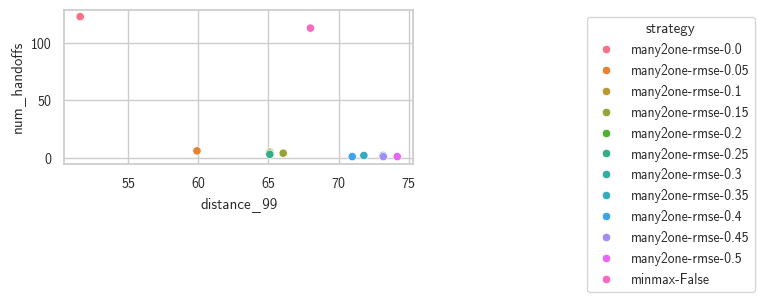

In [19]:
# finally: iotgraph
points = []
point_df = df[(df["experiment"] == "iotgraph")]

# go through unique strategies
for t in point_df["strategy"].unique():
    # figure out the number of handoffs
    num_handoffs = handoff_df[(handoff_df["experiment"] == "iotgraph") & (handoff_df["strategy"] == t)].shape[0]

    # figure out 99 percentile of distance
    distance_99 = point_df[(point_df["strategy"] == t)]["distance"].quantile(0.99) / 1e3 * 2 # convert to ms

    points.append((t, num_handoffs, distance_99))

points_df = pd.DataFrame(points, columns=["strategy", "num_handoffs", "distance_99"])

g = sns.scatterplot(data=points_df, x="distance_99", y="num_handoffs", hue="strategy")
sns.move_legend(g, "upper right", bbox_to_anchor=(2, 1))

In [20]:
# Pretty graphs start here

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_54333/3470062373.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df["Network RTT (ms)"] = graph_df["distance"] / 1e3 * 2
/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_54333/3470062373.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df["Strategy"] = graph_df["strategy"].apply(lambda x: rename[x])
webf NOT subset; don't know how to subset; dropped


                  count      mean       std    min    25%    50%    75%    max
Strategy                                                                      
Heuristic (10%)  1200.0  4.990127  0.695674  4.408  4.432  4.536  5.456  6.548
Heuristic (1ms)  1200.0  5.037253  0.694351  4.408  4.432  5.136  5.456  6.548
Heuristic (25%)  1200.0  5.217688  0.732226  4.408  4.432  5.422  5.464  7.468
MinMax           1200.0  4.984897  0.690296  4.408  4.432  4.536  5.442  6.548


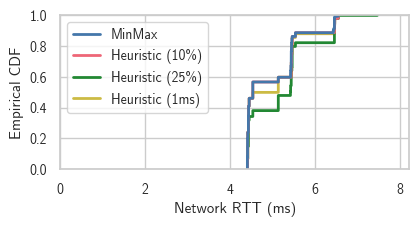

In [21]:
# ecdf for the simple case with distances
graph_df = df[(df["experiment"] == "simple")]

rename = {
    "minmax-False": "MinMax",
    "one2one-0.1": "Heuristic (10%)",
    "one2one-0.25": "Heuristic (25%)",
    "one2one-abs-500": "Heuristic (1ms)",
}

# convert from microsecond one-way to RTT in ms
graph_df["Network RTT (ms)"] = graph_df["distance"] / 1e3 * 2

graph_df["Strategy"] = graph_df["strategy"].apply(lambda x: rename[x])

print(graph_df.groupby("Strategy")["Network RTT (ms)"].describe())

g = sns.ecdfplot(data=graph_df, x="Network RTT (ms)", hue="Strategy", linewidth=2, hue_order=rename.values())
g.set(xlim=(0, max(graph_df["Network RTT (ms)"])*1.1), ylabel="Empirical CDF")
sns.move_legend(g, "upper left", title=None)

plt.savefig(f"{GRAPHS_DIR}/distance_simple.pdf", bbox_inches='tight')

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_54333/2735195948.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df["Time Between Migration (s)"] = graph_df["duration"]
/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_54333/2735195948.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df["Strategy"] = graph_df["strategy"].apply(lambda x: rename[x])
webf NOT subset; don't know how to subset; dropped


                 count        mean        std   min    25%    50%     75%  \
Strategy                                                                    
Heuristic (10%)   12.0   98.416667  53.365734  28.0  56.75  101.5  123.25   
Heuristic (1ms)   12.0   98.416667  44.738550  28.0  59.75  104.0  115.00   
Heuristic (25%)    9.0  127.444444  43.511812  83.0  90.00  118.0  173.00   
MinMax            16.0   68.687500  68.765998   3.0  17.75   37.5  108.50   

                   max  
Strategy                
Heuristic (10%)  182.0  
Heuristic (1ms)  182.0  
Heuristic (25%)  189.0  
MinMax           206.0  


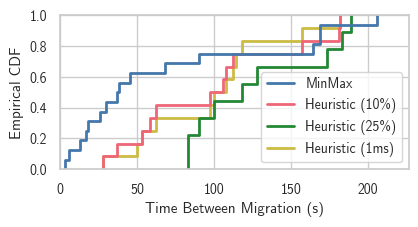

In [22]:
# ecdf for the simple case with distances
graph_df = handoff_df[handoff_df["experiment"] == "simple"]

rename = {
    "minmax-False": "MinMax",
    "one2one-0.1": "Heuristic (10%)",
    "one2one-0.25": "Heuristic (25%)",
    "one2one-abs-500": "Heuristic (1ms)",
}

# convert from microsecond one-way to RTT in ms
graph_df["Time Between Migration (s)"] = graph_df["duration"]

graph_df["Strategy"] = graph_df["strategy"].apply(lambda x: rename[x])

print(graph_df.groupby("Strategy")["Time Between Migration (s)"].describe())

g = sns.ecdfplot(data=graph_df, x="Time Between Migration (s)", hue="Strategy", linewidth=2, hue_order=rename.values())

g.set(xlim=(0, max(graph_df["Time Between Migration (s)"])*1.1), ylabel="Empirical CDF")
sns.move_legend(g, "lower right", title=None)

plt.savefig(f"{GRAPHS_DIR}/handoff_duration_simple.pdf", bbox_inches='tight')

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_54333/2397821777.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df["Network RTT (ms)"] = graph_df["distance"] / 1e3 * 2


                   count       mean        std    min    25%     50%     75%  \
Strategy                                                                       
Heuristic (10%)  36000.0  19.776379  13.577987  3.626  9.698  15.750  26.542   
Heuristic (25%)  36000.0  21.340291  15.527826  3.626  8.930  17.148  30.590   
MinMax           36000.0  19.306265  13.829863  3.626  9.134  15.172  26.162   
Sticky           36000.0  19.688497  15.484854  3.626  8.886  15.012  25.246   

                    max  
Strategy                 
Heuristic (10%)  66.894  
Heuristic (25%)  75.252  
MinMax           69.968  
Sticky           70.362  


webf NOT subset; don't know how to subset; dropped


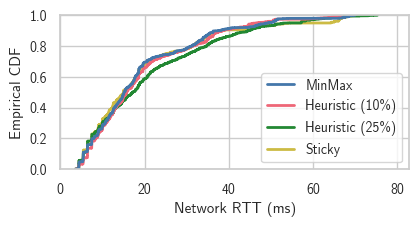

In [23]:
# ecdf for the simple case with distances
graph_df = df[(df["experiment"] == "iot")]

rename = {
    "minmax-False": "MinMax",
    "many2one-rmse-0.1": "Heuristic (10%)",
    "many2one-rmse-0.25": "Heuristic (25%)",
    "sticky": "Sticky",
}

# convert from microsecond one-way to RTT in ms
graph_df["Network RTT (ms)"] = graph_df["distance"] / 1e3 * 2

# filter out what is not in rename.keys
graph_df = graph_df[graph_df["strategy"].apply(lambda x: x in rename.keys())]

graph_df["Strategy"] = graph_df["strategy"].apply(lambda x: rename[x])

print(graph_df.groupby("Strategy")["Network RTT (ms)"].describe())

g = sns.ecdfplot(data=graph_df, x="Network RTT (ms)", hue="Strategy", linewidth=2, hue_order=rename.values())
g.set(xlim=(0, max(graph_df["Network RTT (ms)"])*1.1), ylabel="Empirical CDF")
sns.move_legend(g, "lower right", title=None)

plt.savefig(f"{GRAPHS_DIR}/distance_iot.pdf", bbox_inches='tight')

webf NOT subset; don't know how to subset; dropped


                 count        mean         std    min    25%    50%     75%  \
Strategy                                                                      
Heuristic (10%)    5.0  195.000000   67.966904  111.0  148.0  191.0  256.00   
Heuristic (25%)    3.0  386.000000  111.233988  262.0  340.5  419.0  448.00   
MinMax           113.0   10.327434   13.549145    1.0    2.0    4.0   14.00   
Sticky             4.0  266.750000    4.031129  261.0  265.5  268.0  269.25   

                   max  
Strategy                
Heuristic (10%)  269.0  
Heuristic (25%)  477.0  
MinMax            79.0  
Sticky           270.0  


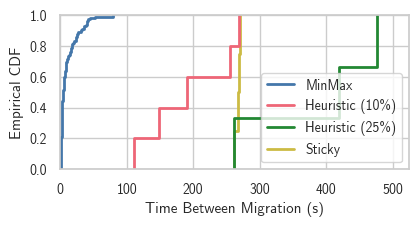

In [24]:
# ecdf for the simple case with distances
graph_df = handoff_df[handoff_df["experiment"] == "iot"]

rename = {
    "minmax-False": "MinMax",
    "many2one-rmse-0.1": "Heuristic (10%)",
    "many2one-rmse-0.25": "Heuristic (25%)",
    "sticky": "Sticky",
}

# filter out what is not in rename.keys
graph_df = graph_df[graph_df["strategy"].apply(lambda x: x in rename.keys())]

# convert from microsecond one-way to RTT in ms
graph_df["Time Between Migration (s)"] = graph_df["duration"]

graph_df["Strategy"] = graph_df["strategy"].apply(lambda x: rename[x])

print(graph_df.groupby("Strategy")["Time Between Migration (s)"].describe())

g = sns.ecdfplot(data=graph_df, x="Time Between Migration (s)", hue="Strategy", linewidth=2, hue_order=rename.values())
sns.move_legend(g, "lower right", title=None)

g.set(xlim=(0, max(graph_df["Time Between Migration (s)"])*1.1), ylabel="Empirical CDF")
plt.savefig(f"{GRAPHS_DIR}/handoff_duration_iot.pdf", bbox_inches='tight')

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_54333/1508707084.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df["Network RTT (ms)"] = graph_df["distance"] / 1e3 * 2


                   count      mean       std    min    25%    50%    75%  \
Strategy                                                                   
Heuristic (10%)  60000.0  4.385725  0.157549  3.636  4.396  4.416  4.436   
Heuristic (1ms)  60000.0  4.786977  0.519756  3.658  4.410  4.440  5.426   
Heuristic (25%)  60000.0  4.727765  0.490249  3.636  4.408  4.436  5.418   
MinMax           60000.0  4.356720  0.156251  3.636  4.384  4.396  4.408   

                   max  
Strategy                
Heuristic (10%)  5.560  
Heuristic (1ms)  6.480  
Heuristic (25%)  6.484  
MinMax           5.438  


webf NOT subset; don't know how to subset; dropped


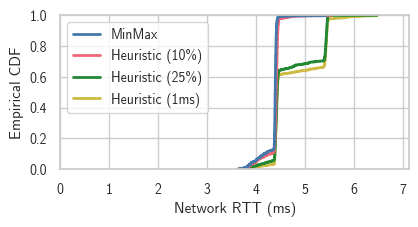

In [25]:
# ecdf for the simple case with distances
graph_df = df[(df["experiment"] == "cdn")]

rename = {
    "minmax-True": "MinMax",
    "many2many-0.1": "Heuristic (10%)",
    "many2many-0.25": "Heuristic (25%)",
    "many2many-abs-1000": "Heuristic (1ms)",
}

# convert from microsecond one-way to RTT in ms
graph_df["Network RTT (ms)"] = graph_df["distance"] / 1e3 * 2

# filter out what is not in rename.keys
graph_df = graph_df[graph_df["strategy"].apply(lambda x: x in rename.keys())]

graph_df["Strategy"] = graph_df["strategy"].apply(lambda x: rename[x])

print(graph_df.groupby("Strategy")["Network RTT (ms)"].describe())

g = sns.ecdfplot(data=graph_df, x="Network RTT (ms)", hue="Strategy", linewidth=2, hue_order=rename.values())
sns.move_legend(g, "upper left", title=None)

g.set(xlim=(0, max(graph_df["Network RTT (ms)"])*1.1), ylabel="Empirical CDF")
plt.savefig(f"{GRAPHS_DIR}/distance_cdn.pdf", bbox_inches='tight')

webf NOT subset; don't know how to subset; dropped


                  count      mean       std  min  25%  50%   75%   max
Strategy                                                              
Heuristic (10%)  1200.0  4.356667  1.595277  2.0  3.0  4.0   6.0  10.0
Heuristic (1ms)  1200.0  1.815000  0.559198  1.0  1.0  2.0   2.0   4.0
Heuristic (25%)  1200.0  2.251667  1.008718  1.0  2.0  2.0   2.0   6.0
MinMax           1200.0  9.848333  2.005912  6.0  8.0  9.0  11.0  15.0


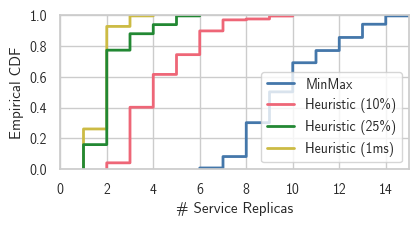

In [26]:
# ecdf for the simple case with distances
graph_df = df[(df["experiment"] == "cdn")].groupby(["t", "strategy"])["satellite"].unique().apply(len).reset_index()

rename = {
    "minmax-True": "MinMax",
    "many2many-0.1": "Heuristic (10%)",
    "many2many-0.25": "Heuristic (25%)",
    "many2many-abs-1000": "Heuristic (1ms)",
}

# filter out what is not in rename.keys
graph_df = graph_df[graph_df["strategy"].apply(lambda x: x in rename.keys())]

# convert from microsecond one-way to RTT in ms
graph_df["# Service Replicas"] = graph_df["satellite"]

graph_df["Strategy"] = graph_df["strategy"].apply(lambda x: rename[x])

print(graph_df.groupby("Strategy")["# Service Replicas"].describe())

g = sns.ecdfplot(data=graph_df, x="# Service Replicas", hue="Strategy", linewidth=2, hue_order=rename.values())
# remove the legend title
sns.move_legend(g, "lower right", title=None)

g.set(xlim=(0, max(graph_df["# Service Replicas"])), ylabel="Empirical CDF")
plt.savefig(f"{GRAPHS_DIR}/num_satellites_cdn.pdf", bbox_inches='tight')

<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_54333/2846162197.py:29: SyntaxWarning: invalid escape sequence '\m'
  g.set(yscale="log", xlim=(50, 76), ylim=(-10, 10**2.3), ylabel="# Service Migrations", xlabel="$\mathregular{99^{th}}$ Percentile Network RTT (ms)")


                      count          mean          std     min     25%  \
strategy                                                                 
many2one-rmse-0.0   36000.0   9871.912389  6122.144018  1813.0  5109.0   
many2one-rmse-0.05  36000.0   9994.890667  6221.948548  1813.0  5252.0   
many2one-rmse-0.1   36000.0   9888.189611  6788.993574  1813.0  4849.0   
many2one-rmse-0.15  36000.0   9883.688583  7401.179785  1813.0  4453.0   
many2one-rmse-0.2   36000.0  10141.849500  7584.955181  1813.0  4192.0   
many2one-rmse-0.25  36000.0  10670.145444  7763.913058  1813.0  4465.0   
many2one-rmse-0.3   36000.0  10538.755917  7899.966701  1813.0  4294.0   
many2one-rmse-0.35  36000.0  11036.141750  8179.435248  1813.0  4528.0   
many2one-rmse-0.4   36000.0  11859.337778  8346.570029  1813.0  5026.0   
many2one-rmse-0.45  36000.0  11683.670472  8679.438536  1813.0  4526.0   
many2one-rmse-0.5   36000.0  12212.522417  8958.826452  1813.0  4849.0   
minmax-False        36000.0   9653.132

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_54333/2846162197.py:29: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  g.set(yscale="log", xlim=(50, 76), ylim=(-10, 10**2.3), ylabel="# Service Migrations", xlabel="$\mathregular{99^{th}}$ Percentile Network RTT (ms)")


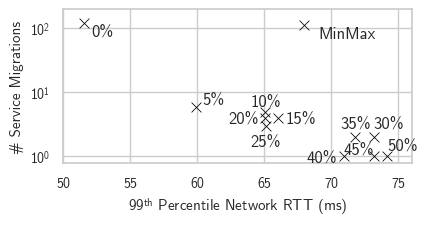

In [27]:
points = []
point_df = df[(df["experiment"] == "iotgraph")]

print(point_df.groupby("strategy")["distance"].describe())

# go through unique strategies
for t in point_df["strategy"].unique():
    # only really care about many2one-rmse and minmax
    if "many2one-rmse" not in t and "minmax" not in t:
        continue

    # figure out the number of handoffs
    num_handoffs = handoff_df[(handoff_df["experiment"] == "iotgraph") & (handoff_df["strategy"] == t)].shape[0]

    # figure out 99 percentile of distance
    distance_99 = point_df[(point_df["strategy"] == t)]["distance"].quantile(0.99) / 1e3 * 2 # convert to ms

    # make a pretty name
    if "many2one-rmse" in t:
        strategy = f'{int(float(t.split("-")[-1]) * 100)}%'
    else:
        strategy = "MinMax"

    points.append((strategy, num_handoffs, distance_99))

graph_df = pd.DataFrame(points, columns=["strategy", "num_handoffs", "distance_99"])

g = sns.scatterplot(data=graph_df, x="distance_99", y="num_handoffs", marker="x", color="black", s=50)
g.set(yscale="log", xlim=(50, 76), ylim=(-10, 10**2.3), ylabel="# Service Migrations", xlabel="$\mathregular{99^{th}}$ Percentile Network RTT (ms)")

# now the fun part: add the labels
label_offsets = {
    "MinMax": (10, 0, "left", "top", False),
    "0%" : (5, 0, "left", "top", False),
    "5%": (5, 0, "left", "bottom", False),
    "10%": (0, 2, "center", "bottom", False),
    "15%": (5, 0, "left", "center", False),
    "20%": (-5, 0, "right", "center", False),
    "25%":(0, -5, "center", "top", False),
    "30%": (0, 5, "left", "bottom", False),
    "35%": (0, 5, "center", "bottom", False),
    "40%": (-5, 0, "right", "center", False),
    "45%":(0, 0, "right", "bottom", False),
    "50%": (0, 3, "left", "bottom", False),
}

for i, row in graph_df.iterrows():
    offset = label_offsets[row["strategy"]]

    g.annotate(row["strategy"], (row["distance_99"], row["num_handoffs"]), textcoords="offset points", xytext=offset[:2], ha=offset[2], va=offset[3], arrowprops=(dict(arrowstyle="-", color='black', lw=0.5) if offset[4] else None), fontsize=12)

# plt.savefig(f"{GRAPHS_DIR}/pareto_iot.pdf", bbox_inches='tight')

<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_54333/3360595964.py:31: SyntaxWarning: invalid escape sequence '\m'
  g.set(yscale="log", xlim=(50, 80), ylabel="# Service Migrations", xlabel="$\mathregular{99^{th}}$ Percentile Network RTT (ms)")
webf NOT subset; don't know how to subset; dropped


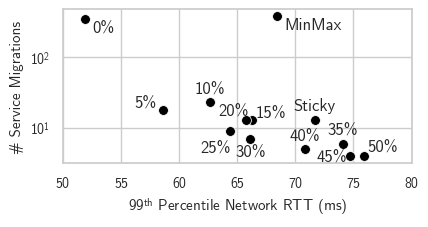

In [28]:
points = []
point_df = df[(df["experiment"] == "iotgraphextreme")]

# go through unique strategies
for t in point_df["strategy"].unique():
    # only really care about many2one-rmse and minmax
    if "many2one-rmse" not in t and "minmax" not in t and "sticky" not in t:
        continue

    # figure out the number of handoffs
    num_handoffs = handoff_df[(handoff_df["experiment"] == "iotgraphextreme") & (handoff_df["strategy"] == t)].shape[0]

    # figure out 99 percentile of distance
    distance_99 = point_df[(point_df["strategy"] == t)]["distance"].quantile(0.99) / 1e3 * 2 # convert to ms

    # make a pretty name
    if "many2one-rmse" in t:
        strategy = f'{int(float(t.split("-")[-1]) * 100)}%'
    elif "minmax" in t:
        strategy = "MinMax"
    elif "sticky" in t:
        strategy = "Sticky"
    else:
        pass

    points.append((strategy, num_handoffs, distance_99))

graph_df = pd.DataFrame(points, columns=["strategy", "num_handoffs", "distance_99"])

g = sns.scatterplot(data=graph_df, x="distance_99", y="num_handoffs", marker="o", color="black", s=50)
g.set(yscale="log", xlim=(50, 80), ylabel="# Service Migrations", xlabel="$\mathregular{99^{th}}$ Percentile Network RTT (ms)")

# now the fun part: add the labels
label_offsets = {
    "MinMax": (5, 0, "left", "top", False),
    "Sticky": (0, 5, "center", "bottom", False),
    "0%" : (5, 0, "left", "top", False),
    "5%": (-5, 0, "right", "bottom", False),
    "10%": (0, 5, "center", "bottom", False),
    "15%": (2, 0, "left", "bottom", False),
    "20%": (2, 2, "right", "bottom", False),
    "25%":(0, -5, "right", "top", False),
    "30%": (0, -3, "center", "top", False),
    "35%": (0, 5, "center", "bottom", False),
    "40%": (0, 5, "center", "bottom", False),
    "45%":(-2, 0, "right", "center", False),
    "50%": (2, 2, "left", "bottom", False),
}

for i, row in graph_df.iterrows():
    offset = label_offsets[row["strategy"]]

    g.annotate(row["strategy"], (row["distance_99"], row["num_handoffs"]), textcoords="offset points", xytext=offset[:2], ha=offset[2], va=offset[3], arrowprops=(dict(arrowstyle="-", color='black', lw=0.5) if offset[4] else None), fontsize=12)

plt.savefig(f"{GRAPHS_DIR}/pareto_iot.pdf", bbox_inches='tight')


In [29]:
print(graph_df.groupby("strategy")["num_handoffs"].describe())

          count   mean  std    min    25%    50%    75%    max
strategy                                                      
0%          1.0  348.0  NaN  348.0  348.0  348.0  348.0  348.0
10%         1.0   23.0  NaN   23.0   23.0   23.0   23.0   23.0
15%         1.0   13.0  NaN   13.0   13.0   13.0   13.0   13.0
20%         1.0   13.0  NaN   13.0   13.0   13.0   13.0   13.0
25%         1.0    9.0  NaN    9.0    9.0    9.0    9.0    9.0
30%         1.0    7.0  NaN    7.0    7.0    7.0    7.0    7.0
35%         1.0    6.0  NaN    6.0    6.0    6.0    6.0    6.0
40%         1.0    5.0  NaN    5.0    5.0    5.0    5.0    5.0
45%         1.0    4.0  NaN    4.0    4.0    4.0    4.0    4.0
5%          1.0   18.0  NaN   18.0   18.0   18.0   18.0   18.0
50%         1.0    4.0  NaN    4.0    4.0    4.0    4.0    4.0
MinMax      1.0  384.0  NaN  384.0  384.0  384.0  384.0  384.0
Sticky      1.0   13.0  NaN   13.0   13.0   13.0   13.0   13.0


In [32]:
print(point_df.groupby("strategy")["distance"].quantile(0.99) / 1e3 * 2)

strategy
many2one-rmse-0.0     51.90800
many2one-rmse-0.05    58.62400
many2one-rmse-0.1     62.66212
many2one-rmse-0.15    66.30800
many2one-rmse-0.2     65.78600
many2one-rmse-0.25    64.41000
many2one-rmse-0.3     66.11600
many2one-rmse-0.35    74.10200
many2one-rmse-0.4     70.84600
many2one-rmse-0.45    74.71200
many2one-rmse-0.5     75.92200
minmax-False          68.44000
sticky                71.65600
Name: distance, dtype: float64


In [30]:
print(point_df.groupby("strategy")["distance"].describe())


                       count          mean          std     min     25%  \
strategy                                                                  
many2one-rmse-0.0   108000.0   9877.251907  6146.067688  1813.0  5099.0   
many2one-rmse-0.05  108000.0  10089.454824  6117.951048  1813.0  5417.0   
many2one-rmse-0.1   108000.0   9821.477972  6801.354182  1813.0  4658.0   
many2one-rmse-0.15  108000.0   9915.199120  7450.399494  1813.0  4438.0   
many2one-rmse-0.2   108000.0  10193.369519  7692.781198  1813.0  4177.0   
many2one-rmse-0.25  108000.0  10753.134806  7704.071505  1813.0  4527.0   
many2one-rmse-0.3   108000.0  11002.264574  7642.310524  1813.0  4756.5   
many2one-rmse-0.35  108000.0  11206.879074  8422.637556  1813.0  4460.0   
many2one-rmse-0.4   108000.0  12222.234528  8359.705191  1813.0  5296.0   
many2one-rmse-0.45  108000.0  12491.482296  8768.507600  1813.0  5296.0   
many2one-rmse-0.5   108000.0  12966.249444  9168.807273  1813.0  5565.0   
minmax-False        10800